In [15]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

#Model

In [16]:
class MLP_T(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(1,128),
        nn.Tanh(),
        nn.Linear(128,128),
        nn.Tanh(),
        nn.Linear(128,1)
    )

  def forward(self,x):
    return self.net(x)

class MLP_V(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(2,128),
        nn.Tanh(),
        nn.Linear(128,128),
        nn.Tanh(),
        nn.Linear(128,1)
    )

  def forward(self,x):
    return self.net(x)

class HNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.T = MLP_T()  # entrée: ω
        self.V = MLP_V()  # entrée: sinθ, cosθ

    def forward(self, X):
        sinθ, cosθ, ω = X[:,0], X[:,1], X[:,2]
        T = self.T(ω.unsqueeze(1))
        V = self.V(torch.stack([sinθ, cosθ], dim=1))
        return T + V

#Training Loop

In [17]:
def hamiltonian_dynamics(model, X_tilde, theta):
    X_tilde = X_tilde.requires_grad_(True)
    H = model(X_tilde).sum()

    grad = torch.autograd.grad(H, X_tilde, create_graph=True)[0]

    dH_dsin = grad[:,0]
    dH_dcos = grad[:,1]
    dH_dw   = grad[:,2]

    dH_dtheta = dH_dsin * torch.cos(theta) - dH_dcos * torch.sin(theta)

    dtheta = dH_dw
    domega = -dH_dtheta

    return dtheta, domega

In [18]:
#-------------
# Load data
#-------------

data = np.load("4.5_HNN_dataset.npz")
split = np.load("4.6_splits_HNN.npz")

X = np.hstack(data["X"])
X = X.reshape(15300, 2)
Y = data["Y"]
Y = Y.reshape(15300, 2)
print(X.shape)
print(Y.shape)

#----------------
# Split data
#----------------

X_train = X[split["train_idx"]]
Y_train = Y[split["train_idx"]]

X_test = X[split["test_idx"]]
Y_test = Y[split["test_idx"]]

#-------------------
# Convert to tensor
#-------------------

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#---------
#  Model
#---------

model = HNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
λ1 = 0.1
λ2 = 0.1
#----------------
# Training loop
#----------------

n_epochs = 350

for epoch in range(n_epochs):
  model.train()
  train_loss = 0.0

  for X_batch, Y_batch in train_loader:

    theta = X_batch[:, 0]
    omega = X_batch[:, 1]

    X_tilde = torch.stack([
        torch.sin(theta),
        torch.cos(theta),
        omega
    ], dim=1)

    dtheta_pred, domega_pred = hamiltonian_dynamics(
        model, X_tilde, theta
    )

    theta_eq = torch.tensor([np.pi], requires_grad=True)
    omega_eq = torch.tensor([0.0])

    x_eq = torch.stack([
        torch.sin(theta_eq),
        torch.cos(theta_eq),
        omega_eq
    ], dim=1)

    H_eq = model(x_eq)

    grad_eq = torch.autograd.grad(
       H_eq,
       x_eq,
       create_graph=True
    )[0]

    loss_eq = grad_eq.pow(2).sum()

    grad_eq_scalar = torch.sum(grad_eq)
    grad2 = torch.autograd.grad(grad_eq_scalar, theta_eq, create_graph=True)[0]
    loss_eq_hessian = torch.relu(-grad2).sum()

    loss = (
        loss_fn(dtheta_pred, Y_batch[:,0]) +
        loss_fn(domega_pred, Y_batch[:,1]) +
        λ1 * loss_eq +
        λ2 * loss_eq_hessian
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    train_loss += loss.item()

  train_loss /= len(train_loader)


  model.eval()
  test_loss = 0.0

  for X_batch, Y_batch in test_loader:
      theta = X_batch[:,0]
      omega = X_batch[:,1]

      X_tilde = torch.stack([
        torch.sin(theta),
        torch.cos(theta),
        omega
      ], dim=1)

      dtheta_pred, domega_pred = hamiltonian_dynamics(
        model, X_tilde, theta
      )

      loss = (
        loss_fn(dtheta_pred, Y_batch[:,0]) +
        loss_fn(domega_pred, Y_batch[:,1])
      )
      test_loss += loss.item()

  test_loss /= len(test_loader)
  print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#-------------
# Save model
#-------------

torch.save(model.state_dict(), "Upgrade_HNN_v2.pth")

(15300, 2)
(15300, 2)
Epoch 1/350, Train Loss: 22.8925, Test Loss: 7.3882
Epoch 2/350, Train Loss: 4.3175, Test Loss: 1.4010
Epoch 3/350, Train Loss: 1.2095, Test Loss: 0.3259
Epoch 4/350, Train Loss: 0.4646, Test Loss: 0.1213
Epoch 5/350, Train Loss: 0.2021, Test Loss: 0.0674
Epoch 6/350, Train Loss: 0.0724, Test Loss: 0.0375
Epoch 7/350, Train Loss: 0.0312, Test Loss: 0.0225
Epoch 8/350, Train Loss: 0.0194, Test Loss: 0.0155
Epoch 9/350, Train Loss: 0.0138, Test Loss: 0.0116
Epoch 10/350, Train Loss: 0.0102, Test Loss: 0.0088
Epoch 11/350, Train Loss: 0.0080, Test Loss: 0.0069
Epoch 12/350, Train Loss: 0.0063, Test Loss: 0.0057
Epoch 13/350, Train Loss: 0.0051, Test Loss: 0.0049
Epoch 14/350, Train Loss: 0.0044, Test Loss: 0.0040
Epoch 15/350, Train Loss: 0.0035, Test Loss: 0.0032
Epoch 16/350, Train Loss: 0.0031, Test Loss: 0.0028
Epoch 17/350, Train Loss: 0.0026, Test Loss: 0.0025
Epoch 18/350, Train Loss: 0.0022, Test Loss: 0.0020
Epoch 19/350, Train Loss: 0.0020, Test Loss: 0.001

#Results

In [19]:
def pendulum_dynamics(x, u, params):  # Compute the function f(x,t) such that theta'' = f(x,t)
  theta, omega = x
  m, l, g = params["m"], params["l"], params["g"]
  u = float(u)

  d_theta = omega
  d_omega = (g/l) * np.sin(theta) + u/(m * l**2)

  return np.array([d_theta, d_omega])

def rk4_step(f, x, u, dt, params):  # Compute the position after a short time dt based on the pervious position using rk4 method
  k1 = f(x, u, params)
  k2 = f(x + 0.5 * dt * k1, u, params)
  k3 = f(x + 0.5 * dt * k2, u, params)
  k4 = f(x + dt * k3, u, params)

  return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation(x0, u_control, dt, T, params):  # Compute the trajectory using rk4_step at each step
  N = int(T/dt)
  x = np.zeros((N+1, 2))
  x[0] = x0

  for t in range(N):
    u = u_control(t * dt, x[t])
    x[t+1] = rk4_step(pendulum_dynamics, x[t], u, dt, params)
  return x


def zero_control(t,x):
  return 0

def hamiltonian_dynamics_simulation(model, x):
    if x.dim() == 1:
        x = x.unsqueeze(0)

    theta = x[:,0]
    omega = x[:,1]

    X_tilde = torch.stack([torch.sin(theta), torch.cos(theta), omega], dim=1)
    X_tilde = X_tilde.requires_grad_(True)
    H = model(X_tilde).sum()

    grad = torch.autograd.grad(H, X_tilde, create_graph=True)[0]

    dH_dsin = grad[:,0]
    dH_dcos = grad[:,1]
    dH_dw   = grad[:,2]

    dH_dtheta = dH_dsin * torch.cos(theta) - dH_dcos * torch.sin(theta)

    dtheta = dH_dw
    domega = -dH_dtheta

    dx = torch.stack([dtheta, domega], dim=1)

    return dx.squeeze(0) if dx.shape[0] == 1 else dx


def rk4_step_HNN(f, x, dt):   # rk4_step but adapted for the HNN
    k1 = hamiltonian_dynamics_simulation(f, x)
    k2 = hamiltonian_dynamics_simulation(f, x + 0.5 * dt * k1)
    k3 = hamiltonian_dynamics_simulation(f, x + 0.5 * dt * k2)
    k4 = hamiltonian_dynamics_simulation(f, x + dt * k3)
    return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation_HNN(x0, dt, T):  # adapted version for the HNN
    N = int(T / dt)
    x = torch.zeros((N+1, 2))
    x[0] = torch.tensor(x0, dtype=torch.float32)

    for t in range(N):
        x[t+1] = rk4_step_HNN(model, x[t], dt).detach()

    return x.detach().numpy()

def dH_dt(model, x):
    if x.dim() == 1:
        x = x.unsqueeze(0)

    theta = x[:, 0]
    omega = x[:, 1]

    X_tilde = torch.stack(
        [torch.sin(theta), torch.cos(theta), omega],
        dim=1
    ).requires_grad_(True)   # network input

    H = model(X_tilde).sum() # hamiltonian

    grad = torch.autograd.grad(H, X_tilde, create_graph=True)[0]

    dH_dsin = grad[:, 0]
    dH_dcos = grad[:, 1]
    dH_dω   = grad[:, 2]

    dH_dθ = dH_dsin * torch.cos(theta) - dH_dcos * torch.sin(theta) # chain rule

    dθ = dH_dω
    dω = -dH_dθ

    dHdt = dH_dθ * dθ + dH_dω * dω

    return dHdt.squeeze()


def mechanical_energy(x, params):    # Verification that Em is roughly constant
  m, l, g = params["m"], params["l"], params["g"]
  theta = x[:,0]
  omega = x[:,1]

  E = 0.5 * m * l**2 * omega**2 + m * g * l * np.cos(theta)
  return E


tensor(0., grad_fn=<SqueezeBackward0>)
(501, 2)
(501, 2)
(501,)


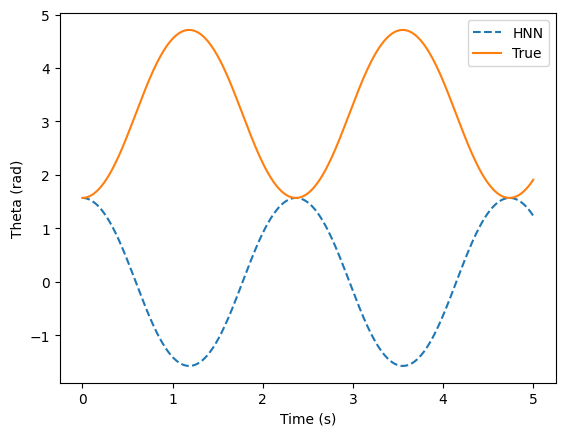

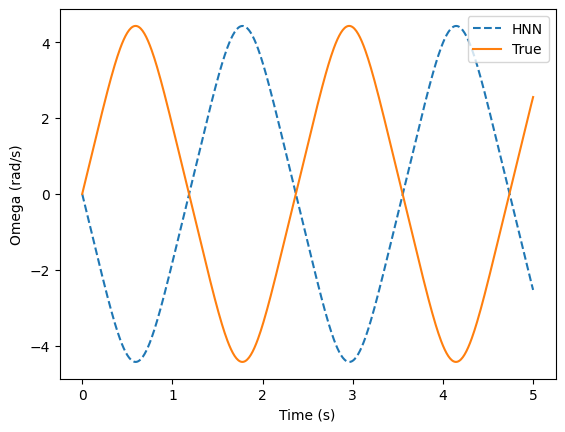

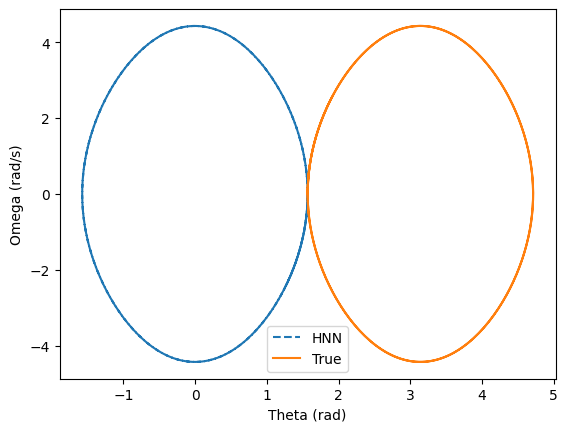

In [20]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}

x0 = [1.57, 0]

HNN_trajectory = []
true_trajectory = []
T = 5.0 # 5s
dt = 0.01 # 500 step

#--------------
# Trajectories
#--------------

HNN_trajectory = trajectory_simulation_HNN(x0, dt, T)

true_trajectory = trajectory_simulation(x0, zero_control, dt, T, params=params)

print( dH_dt(model, torch.tensor(x0, dtype=torch.float32)))

#-------
# Plot
#-------

t = np.arange(start=0, stop = 5.001, step = dt)

print(HNN_trajectory.shape)
print(true_trajectory.shape)
print(t.shape)

plt.plot(t, np.array(HNN_trajectory)[:,0], "--")
plt.plot(t, np.array(true_trajectory)[:,0])
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend(["HNN", "True"])
plt.show()

plt.plot(t, np.array(HNN_trajectory)[:,1], "--")
plt.plot(t, np.array(true_trajectory)[:,1])
plt.xlabel("Time (s)")
plt.ylabel("Omega (rad/s)")
plt.legend(["HNN", "True"])
plt.show()

plt.figure()
plt.plot(np.array(HNN_trajectory)[:,0], np.array(HNN_trajectory)[:,1], "--")
plt.plot(np.array(true_trajectory)[:,0], np.array(true_trajectory)[:,1])
plt.legend(["HNN", "True"])
plt.xlabel("Theta (rad)")
plt.ylabel("Omega (rad/s)")
plt.show()
